In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale
from sklearn import tree, svm, metrics
import matplotlib.pyplot as plt
import os
import glob

pd.set_option('display.max_columns', None)

## More Cleaning

In [2]:
path = os.getcwd()
path = path + '\scraped_data_final'
csv_files = glob.glob(os.path.join(path, '*.csv'))
df_list = []
label_list = []
for f in csv_files:
    df_list.append(pd.read_csv(f))
    if 'mid_team' in f:
        label_list.append(3)
    elif 'worst_team' in f:
        label_list.append(4)
    elif 'runn_up' in f:
        label_list.append(2)
    else:
        label_list.append(1)

In [3]:
df_list[0].head()

Unnamed: 0  Rk  Gtm   Date Unnamed: 3  Opp    Rslt  PA  AB   R   H  2B  3B  \
0           0   1    1  Apr 3        NaN  NYY   L,2-3  40  35   2  10   1   0   
1           1   2    2  Apr 4        NaN  NYY   L,3-5  42  36   3  10   0   0   
2           2   3    3  Apr 5        NaN  NYY  W,12-6  44  33  12  12   4   0   
3           3   4    4  Apr 7        NaN  BOS   W,7-3  38  32   7   9   2   0   
4           4   5    5  Apr 8        NaN  BOS   W,7-5  37  35   7  13   4   0   

   HR  RBI  BB  IBB  SO  HBP  SH  SF  ROE  GDP  SB  CS     BA    OBP    SLG  \
0   1    2   5    0   6    0   0   0    0    0   0   1  0.286  0.375  0.400   
1   0    3   6    0   9    0   0   0    1    2   1   0  0.282  0.378  0.338   
2   1   12   8    0   4    1   0   2    0    0   1   0  0.308  0.413  0.413   
3   2    7   5    2   5    0   1   0    0    0   3   0  0.301  0.405  0.441   
4   1    7   1    0   4    0   1   0    0    0   0   1  0.316  0.402  0.468   

     OPS  LOB   # Thr Opp. Starter (GmeSc)  
0  0.775   11  11   R      O.Hernandez(58)  
1  0.716   12   9   R        R.Clemens(54)  
2  0.826    8  10   R           D.Cone(14)  
3  0.846    7  10   L       P.Schourek(47)  
4  0.870    6  10   R           B.Rose(29)

In [4]:
for i in range(len(df_list)):
    try:
        df_list[i] = df_list[i].drop(['Unnamed: 0', 'Rk', 'Gtm', 'Date', 'Unnamed: 3', 'Opp', 'Umpire', 'Pitchers Used (Rest-GameScore-Dec)'], axis=1)
    except:
        pass
    try:
        df_list[i] = df_list[i].drop(['Unnamed: 0', 'Rk', 'Gtm', 'Date', 'Unnamed: 3', 'Opp', 'Thr', 'Opp. Starter (GmeSc)'], axis=1)
    except:
        pass

In [5]:
df_list[30].head()

Rslt    IP   H  R  ER  UER  BB  SO  HR  HBP   ERA  BF  Pit  Str   IR  \
0   W,9-2   9.0   9  2   2    0   0   7   0    0  2.00  36  137   96  0.0   
1  W,10-2   9.0   7  2   2    0   3   5   1    2  2.00  37  143   95  2.0   
2   W,6-3  12.0   7  3   3    0   6  12   0    0  2.10  50  198  125  3.0   
3   L,0-4   8.0   8  4   4    0   2   5   1    0  2.61  34  115   76  0.0   
4   L,5-6  11.1  11  6   6    0   7   9   0    2  3.10  52  232  135  2.0   

    IS  SB  CS  AB  2B  3B  IBB  SH  SF  ROE  GDP  #  
0  0.0   0   0  36   1   1    0   0   0    0    0  3  
1  0.0   0   0  32   1   0    0   0   0    0    2  4  
2  0.0   0   0  43   2   0    0   1   0    1    0  7  
3  0.0   1   0  32   1   0    0   0   0    0    0  2  
4  2.0   0   0  43   4   1    2   0   0    0    2  6

In [6]:
for i in range(len(df_list)):
    temp = []
    temp_our_score = []
    temp_their_score = []
    temp_diff_score = []
    for j in range(len(df_list[i]['Rslt'])):
        
        temp_str_array = df_list[i]['Rslt'][j].split(',')
        temp_score_array = temp_str_array[1].split('-')
        
        temp_our_score.append(int(temp_score_array[0]))
        temp_their_score.append(int(temp_score_array[1]))
        temp_diff_score.append(int(temp_score_array[0]) - int(temp_score_array[1]))
        
        if 'W' in df_list[i]['Rslt'][j]:
            temp.append(1)
        elif 'L' in df_list[i]['Rslt'][j]:
            temp.append(0)
        else:
            temp.append(-1)
    df_list[i]['Result Binary'] = temp
    df_list[i]['Our Score'] = temp_our_score
    df_list[i]['Their Score'] = temp_their_score
    df_list[i]['Score Differential'] = temp_diff_score
    df_list[i] = df_list[i].drop(['Rslt'], axis=1)

# for i in range(len(df_list)):
#     df_list[i]['Results Binary'] = np.where('W' in df_list[i]['Rslt'], 1, 0)

In [7]:
print(df_list[0].columns)
print(len(df_list[0].columns))
print(len(df_list[30].columns))
df_list[0].head()

Index(['PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP',
       'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'LOB',
       '#', 'Result Binary', 'Our Score', 'Their Score', 'Score Differential'],
      dtype='object')
28
30


PA  AB   R   H  2B  3B  HR  RBI  BB  IBB  SO  HBP  SH  SF  ROE  GDP  SB  \
0  40  35   2  10   1   0   1    2   5    0   6    0   0   0    0    0   0   
1  42  36   3  10   0   0   0    3   6    0   9    0   0   0    1    2   1   
2  44  33  12  12   4   0   1   12   8    0   4    1   0   2    0    0   1   
3  38  32   7   9   2   0   2    7   5    2   5    0   1   0    0    0   3   
4  37  35   7  13   4   0   1    7   1    0   4    0   1   0    0    0   0   

   CS     BA    OBP    SLG    OPS  LOB   #  Result Binary  Our Score  \
0   1  0.286  0.375  0.400  0.775   11  11              0          2   
1   0  0.282  0.378  0.338  0.716   12   9              0          3   
2   0  0.308  0.413  0.413  0.826    8  10              1         12   
3   0  0.301  0.405  0.441  0.846    7  10              1          7   
4   1  0.316  0.402  0.468  0.870    6  10              1          7   

   Their Score  Score Differential  
0            3                  -1  
1            5                  -2  
2            6                   6  
3            3                   4  
4            5                   2

## Analysis 1 - kNN
 - Compare prediction scores of batting vs pitching
 - Graph accuracy of preditions vs games used in predicting
 - Change percentage of test_size
 - Make a giant array with all variables. Find a way to track the variable within the model...?

In [9]:
X_batting = np.array([df_list[i]['HR'][0:20].values for i in range(len(df_list)) if len(df_list[i].columns) == 28])
X_pitching = np.array([df_list[i]['SO'][0:20].values for i in range(len(df_list)) if len(df_list[i].columns) == 30])
y_batting = np.array([label_list[i] for i in range(len(label_list)) if len(df_list[i].columns) == 28])
y_pitching = np.array([label_list[i] for i in range(len(label_list)) if len(df_list[i].columns) == 30])

# X_batting = scale(X_batting)
# X_pitching = scale(X_pitching)

X_train, X_test, y_train, y_test = train_test_split(X_pitching, y_pitching, random_state=1, test_size=0.7)

In [10]:
print(type(X_batting[0]))
print(type(y_batting))
print(y_batting)
print(X_batting)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[[1 0 1 ... 0 0 4]
 [1 2 0 ... 2 2 2]
 [3 1 2 ... 0 0 0]
 ...
 [2 1 0 ... 2 2 1]
 [1 1 0 ... 5 1 0]
 [1 1 0 ... 1 0 0]]


In [11]:
# acc = []
# max_acc = -1
# for i in range(2, 10):
#     current_model = KNeighborsClassifier(n_neighbors = i)
#     scores = cross_val_score(estimator= current_model, X= df_list_batting, y= label_list_batting, cv=5, scoring='accuracy')
#     av = np.mean(scores)
    
#     acc.append(av)
#     if av > max_acc:
#         max_acc = av
#         max_k = i

# A
model = KNeighborsClassifier(n_neighbors = 10)
model.fit(X_pitching, y_pitching)

# B
y_pred = model.predict(X_test)
print('Accuracy = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
print(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred))

Accuracy =  0.5483870967741935
[[ 2  3  4  5]
 [ 2  9  3  3]
 [ 2  2 18  6]
 [ 5  2  5 22]]


c:\Users\attig\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [13]:
batting_prediction_accuracy = []
num_of_games_batting = []
for j in range(len(df_list[0].columns)):
    accuracy = []
    x_range = []
    for k in range(10, 150):
        try:
            X_batting = np.array([df_list[i][df_list[i].columns[j]][0:k].values for i in range(len(df_list)) if len(df_list[i].columns) == 28])
            y_batting = np.array([label_list[i] for i in range(len(label_list)) if len(df_list[i].columns) == 28])
            
            X_train, X_test, y_train, y_test = train_test_split(X_batting, y_batting, random_state=1, test_size=0.7)
            
            model = KNeighborsClassifier(n_neighbors = 10)
            model.fit(X_batting, y_batting)

            y_pred = model.predict(X_test)
            accuracy.append(metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
            x_range.append(k)
        except:
            pass
        
    batting_prediction_accuracy.append(accuracy)
    num_of_games_batting.append(x_range)
            
pitching_prediction_accuracy = []
num_of_games_pitching = []
for j in range(len(df_list[30].columns)):
    accuracy = []
    x_range = []
    for k in range(10, 150):
        try:
            X_pitching = np.array([df_list[i][df_list[i].columns[j]][0:k].values for i in range(len(df_list)) if len(df_list[i].columns) == 30])
            y_pitching = np.array([label_list[i] for i in range(len(label_list)) if len(df_list[i].columns) == 30])
            
            X_train, X_test, y_train, y_test = train_test_split(X_pitching, y_pitching, random_state=1, test_size=0.7)
            
            model = KNeighborsClassifier(n_neighbors = 10)
            model.fit(X_pitching, y_pitching)

            y_pred = model.predict(X_test)
            accuracy.append(metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
            x_range.append(k)
        except:
            pass
        
    pitching_prediction_accuracy.append(accuracy)
    num_of_games_pitching.append(x_range)
        

c:\Users\attig\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\attig\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

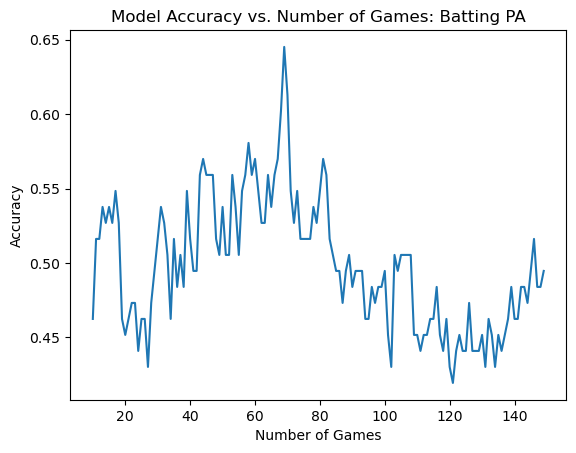

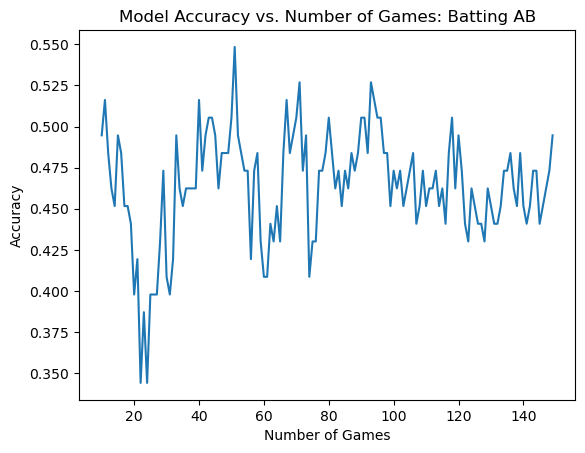

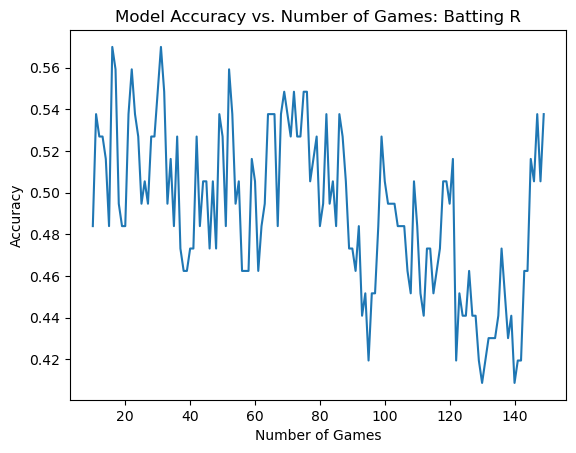

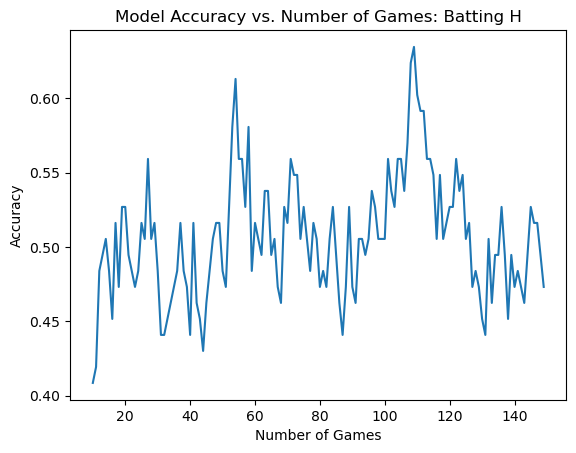

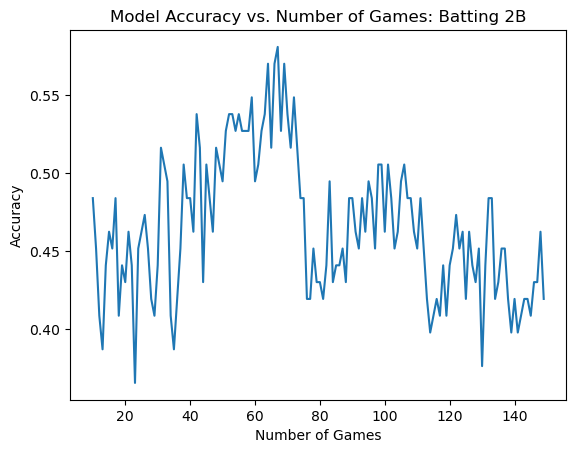

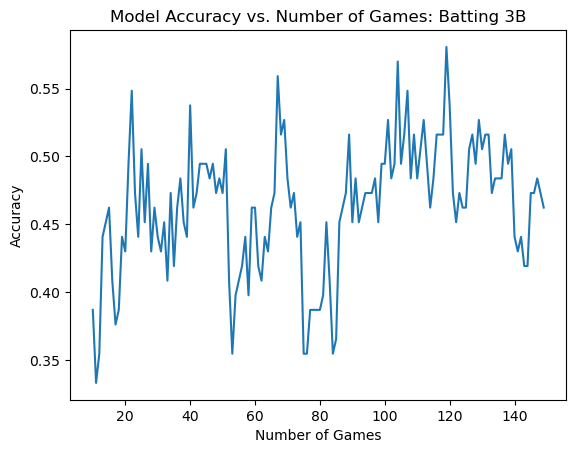

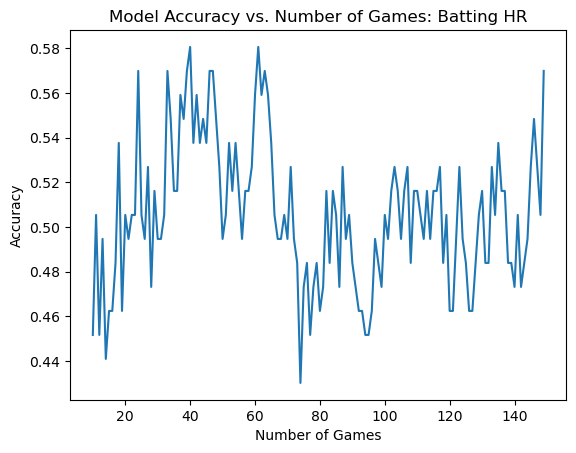

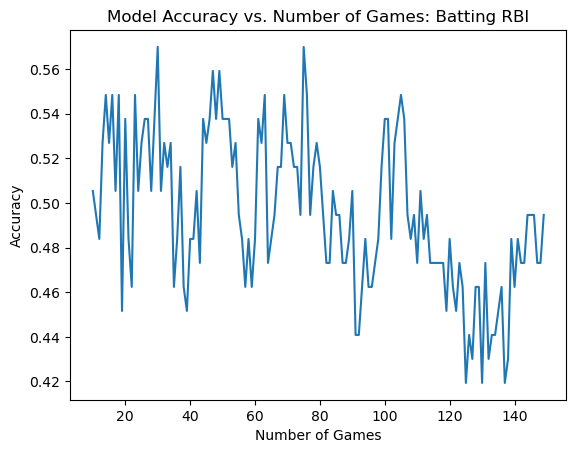

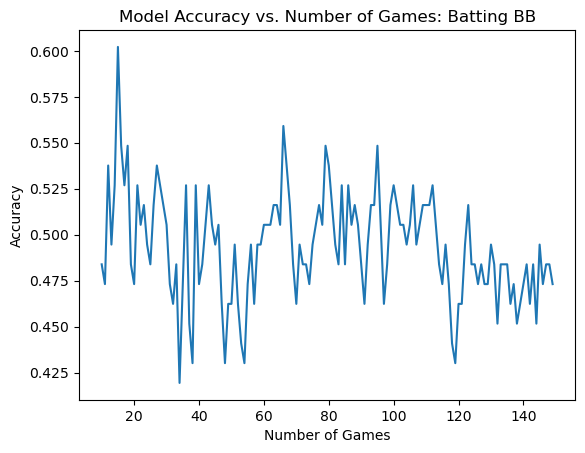

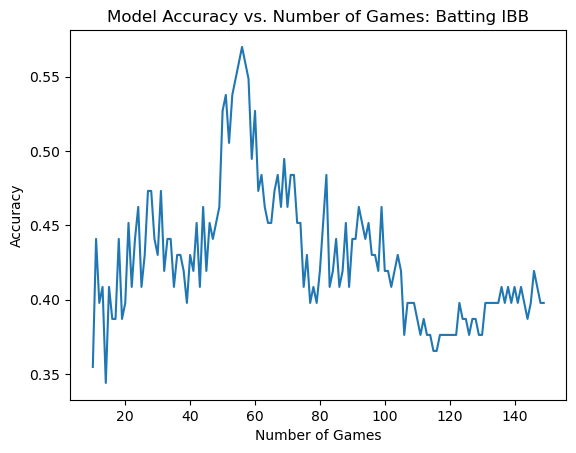

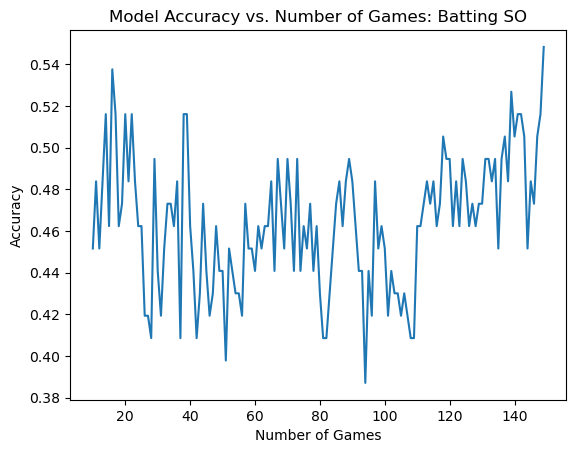

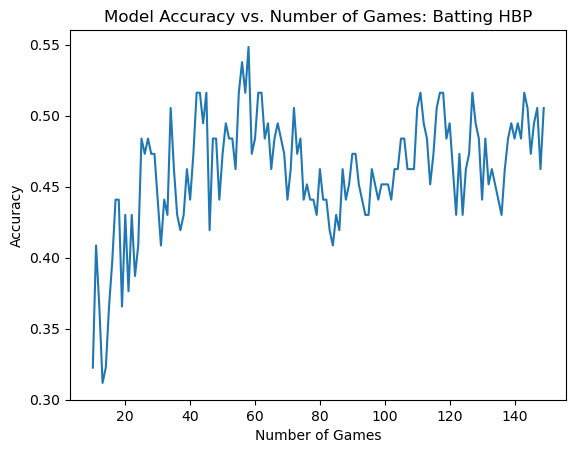

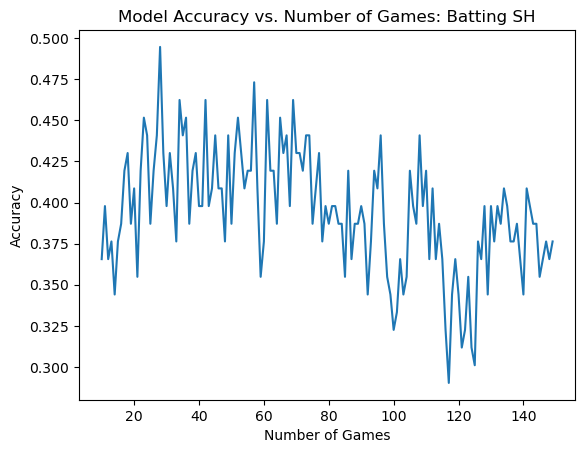

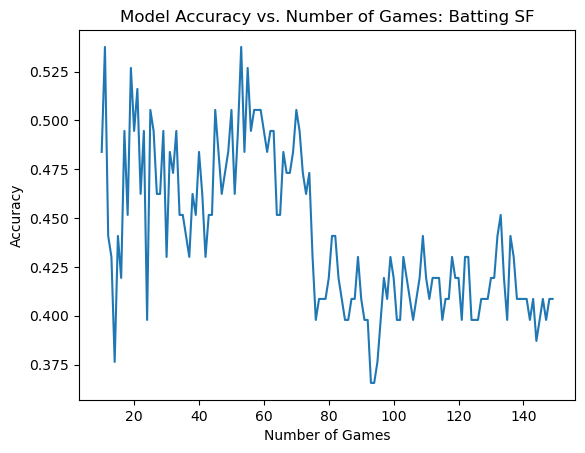

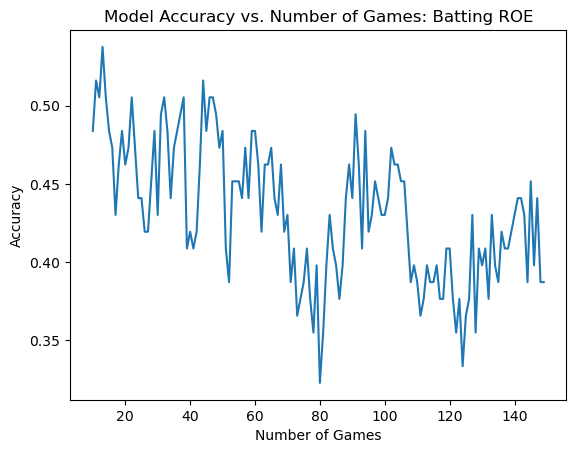

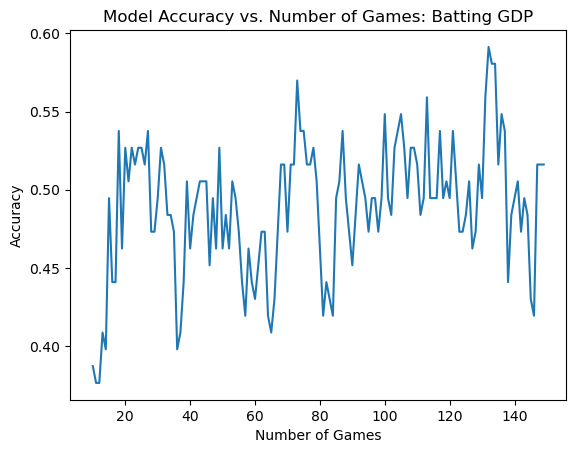

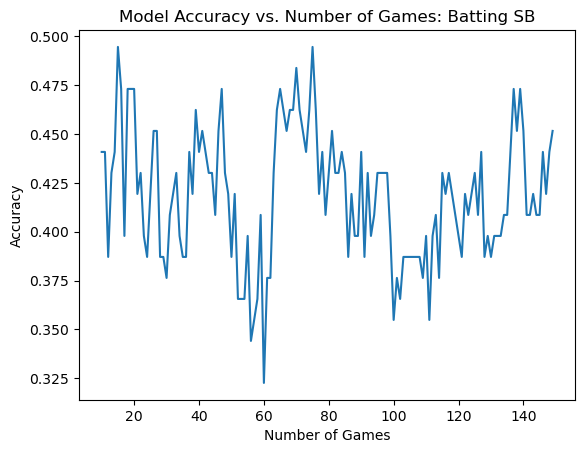

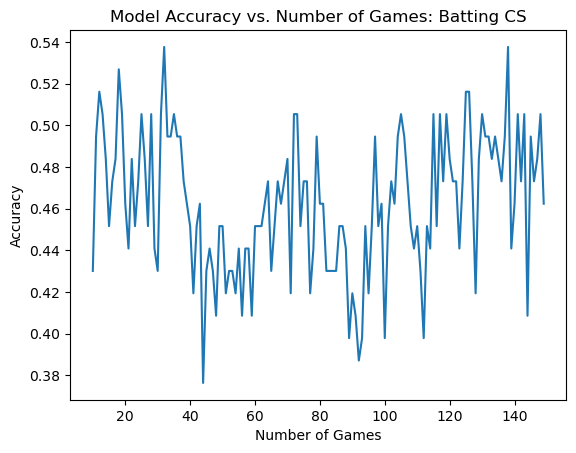

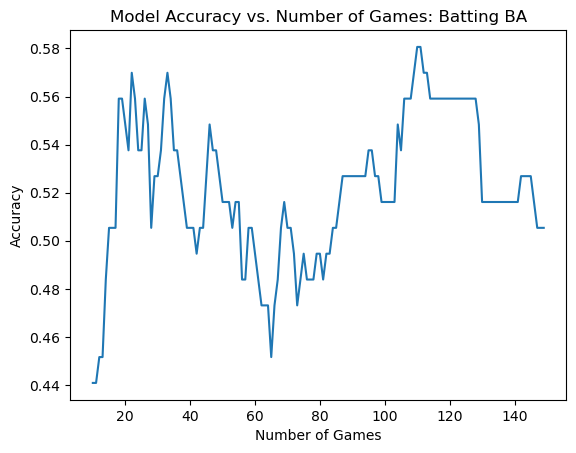

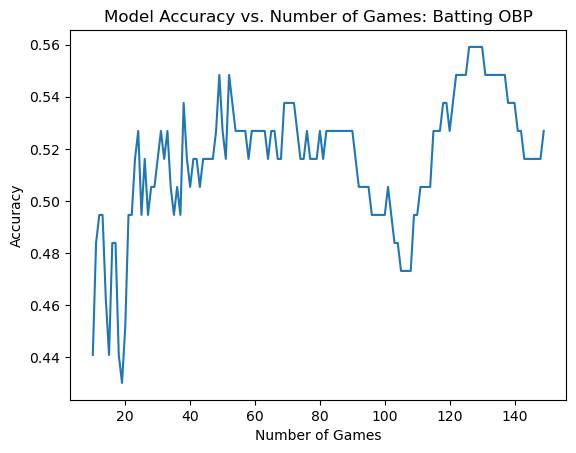

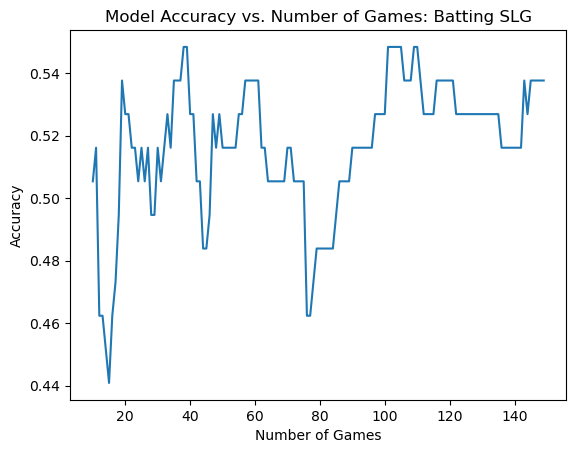

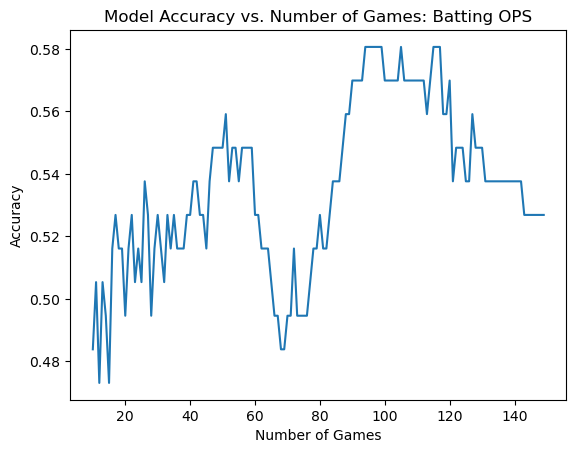

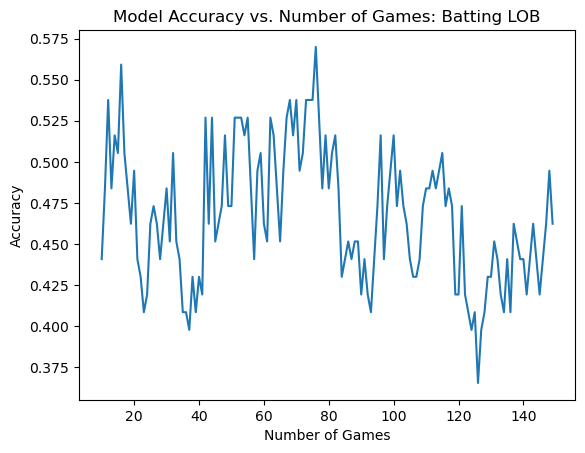

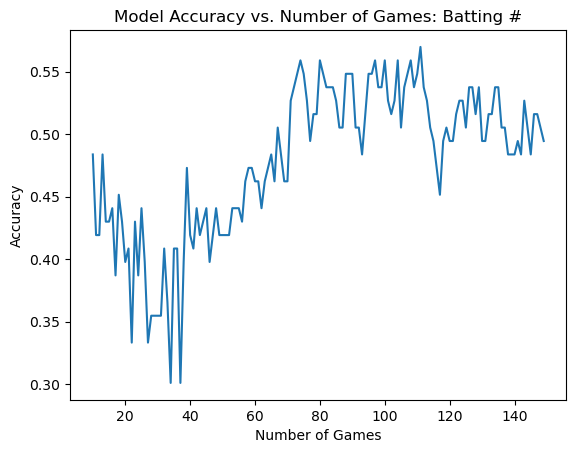

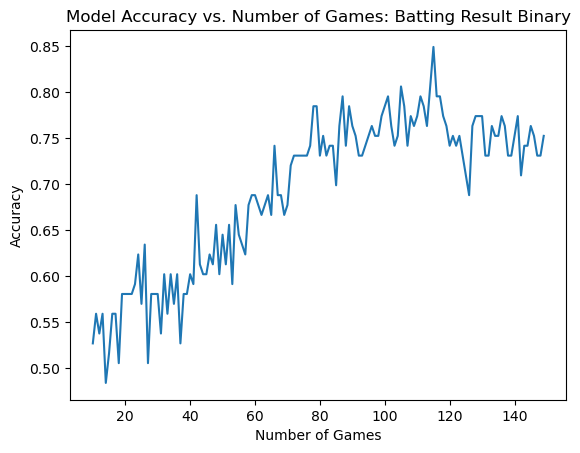

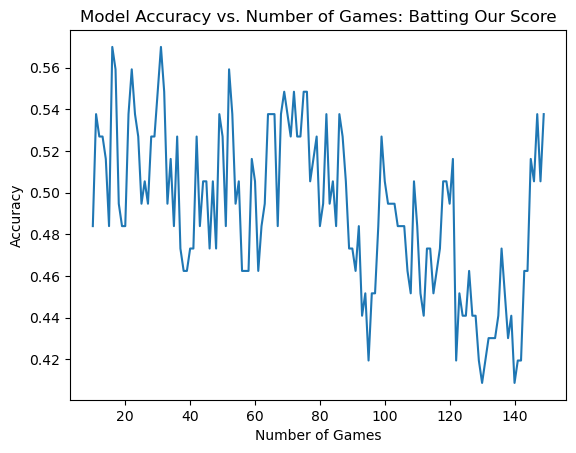

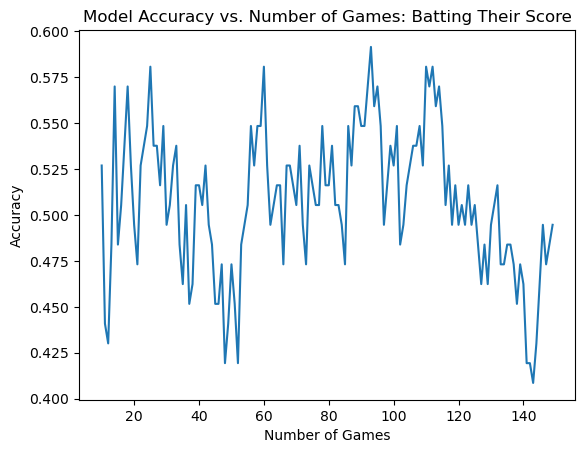

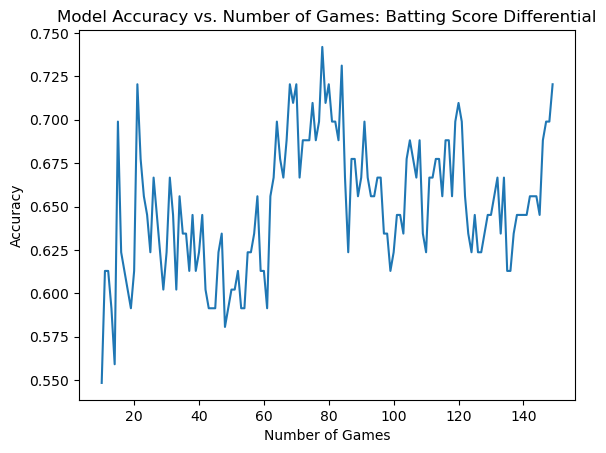

In [30]:
for i in range(len(df_list[0].columns)):
    plt.plot(num_of_games_batting[i], batting_prediction_accuracy[i])
    plt.title(f'Model Accuracy vs. Number of Games: Batting {df_list[0].columns[i]}')
    plt.xlabel(f'Number of Games')
    plt.ylabel(f'Accuracy')
    plt.savefig(f'Batting Model Accuracy__{df_list[0].columns[i]}.jpg')
    plt.show()

# for i in range(len(df_list[0].columns)):
#     plt.plot(num_of_games_batting[i], batting_prediction_accuracy[i])
    
# plt.title(f'Model Accuracy vs. Number of Games: Batting')
# plt.legend([f'{df_list[0].columns[i]}' for i in range(len(df_list[0].columns))])
# plt.xlabel(f'Number of Games')
# plt.ylabel(f'Accuracy')
# plt.savefig('Batting Accuracy.jpg')
# plt.show()


In [41]:
avg_acc_batting = np.mean(batting_prediction_accuracy, axis=1)

print(f'{df_list[0].columns[27]}, average accuracy: {avg_acc_batting[27]}')
print(f'{df_list[0].columns[24]}, average accuracy: {avg_acc_batting[24]}')
print(f'{df_list[0].columns[21]}, average accuracy: {avg_acc_batting[21]}')
print(f'{df_list[0].columns[20]}, average accuracy: {avg_acc_batting[20]}')
print(f'{df_list[0].columns[19]}, average accuracy: {avg_acc_batting[19]}')
print(f'{df_list[0].columns[18]}, average accuracy: {avg_acc_batting[18]}')
print()
print()
print()
print(f'{df_list[0].columns[12]}, average accuracy: {avg_acc_batting[12]}')
print(f'{df_list[0].columns[14]}, average accuracy: {avg_acc_batting[14]}')
print(f'{df_list[0].columns[16]}, average accuracy: {avg_acc_batting[16]}')
print(f'{df_list[0].columns[9]}, average accuracy: {avg_acc_batting[9]}')
print(f'{df_list[0].columns[13]}, average accuracy: {avg_acc_batting[13]}')

Score Differential, average accuracy: 0.650537634408602
Result Binary, average accuracy: 0.6915514592933949
OPS, average accuracy: 0.5354838709677417
SLG, average accuracy: 0.5168202764976959
OBP, average accuracy: 0.5161290322580645
BA, average accuracy: 0.5215821812596007



SH, average accuracy: 0.3944700460829494
ROE, average accuracy: 0.4318740399385561
SB, average accuracy: 0.41835637480798776
IBB, average accuracy: 0.4284178187403994
SF, average accuracy: 0.4407834101382489


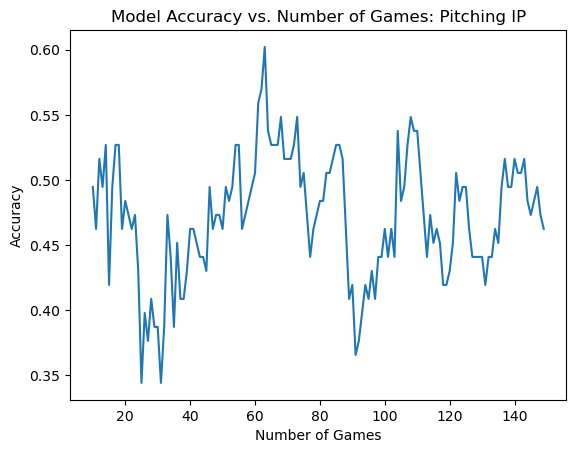

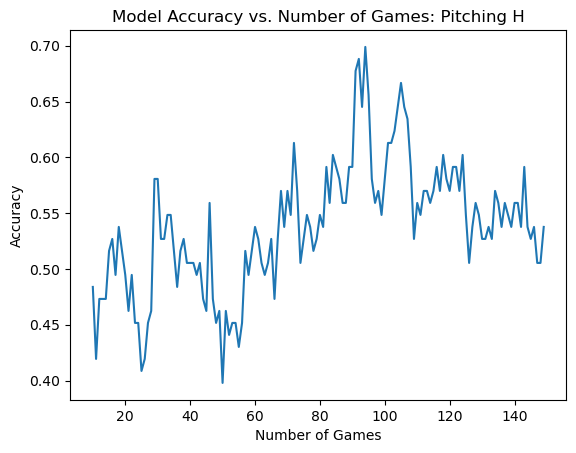

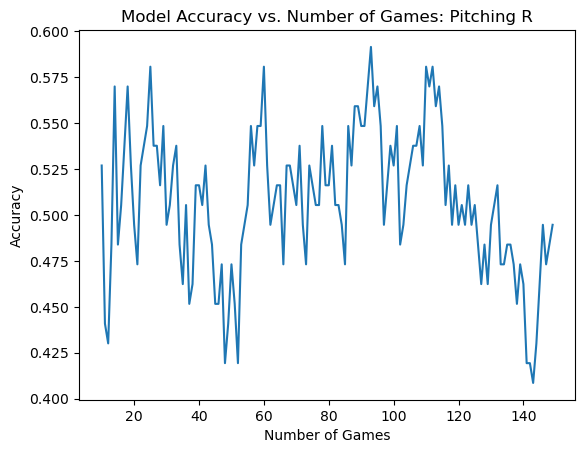

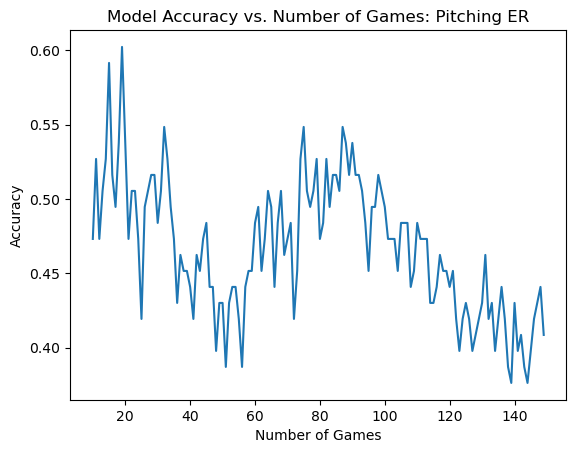

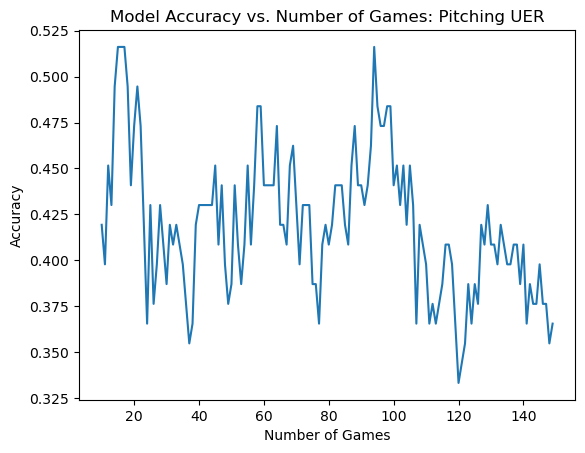

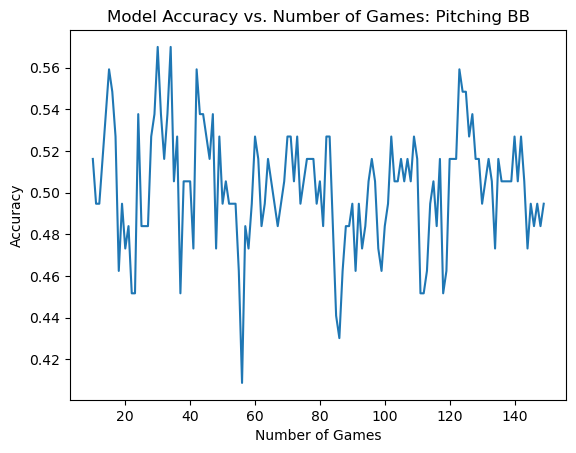

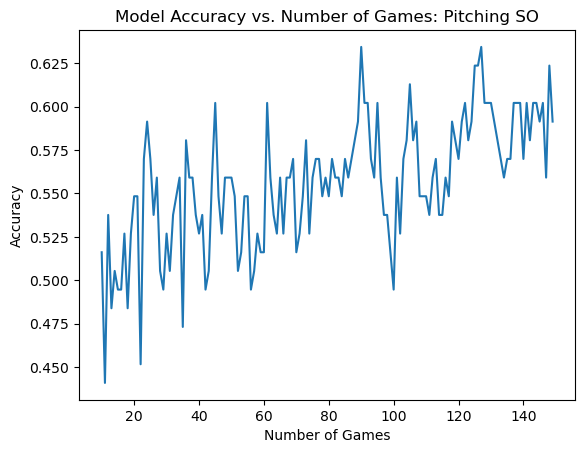

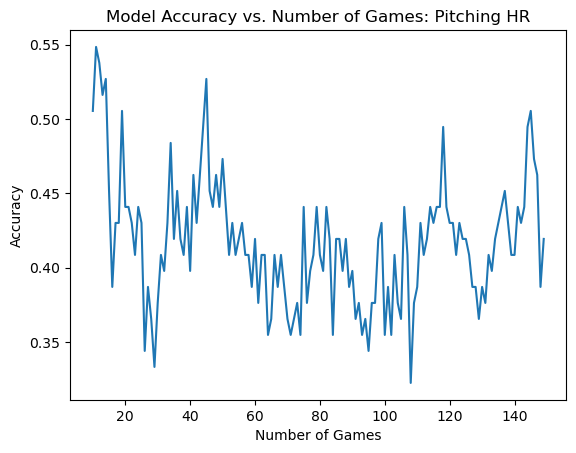

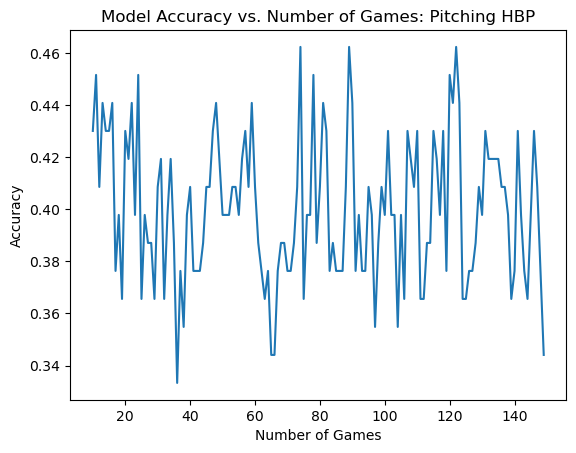

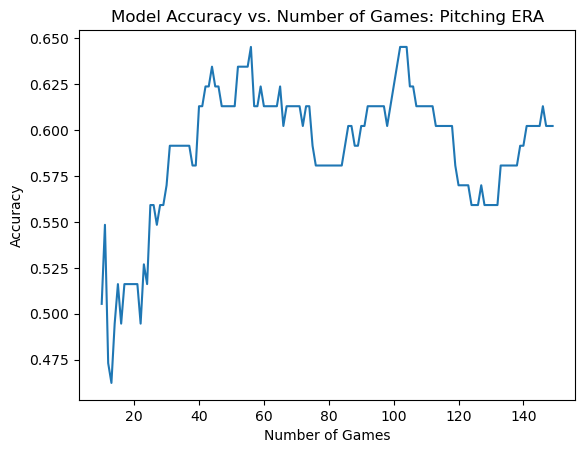

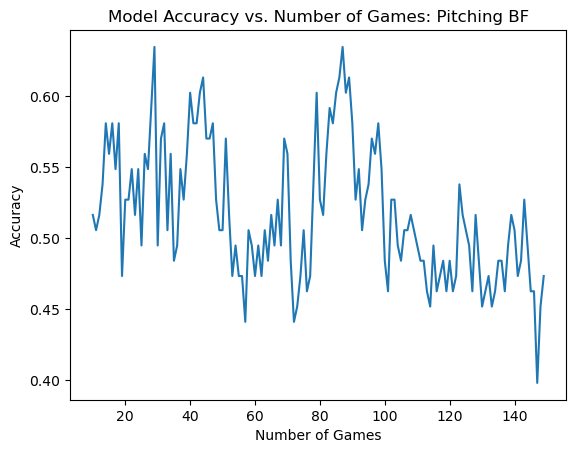

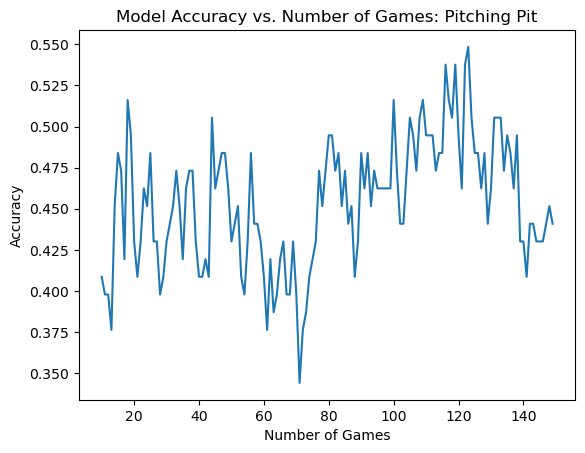

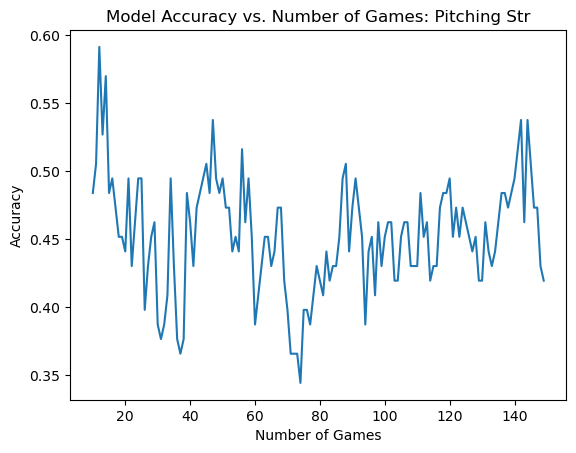

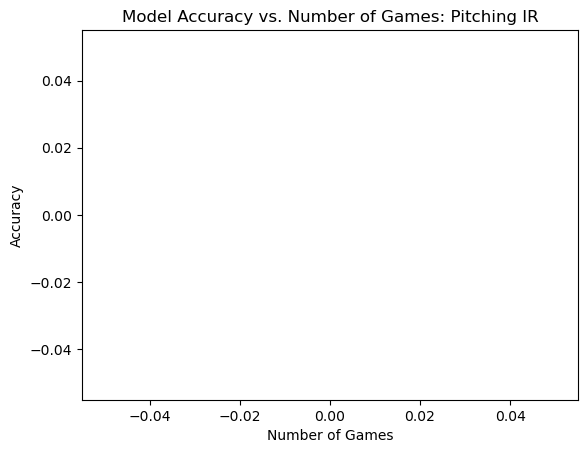

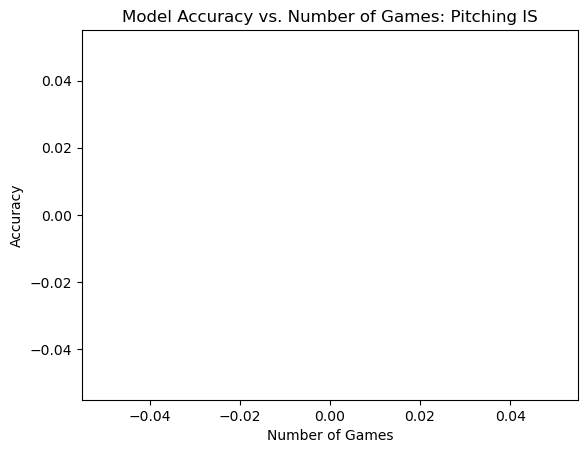

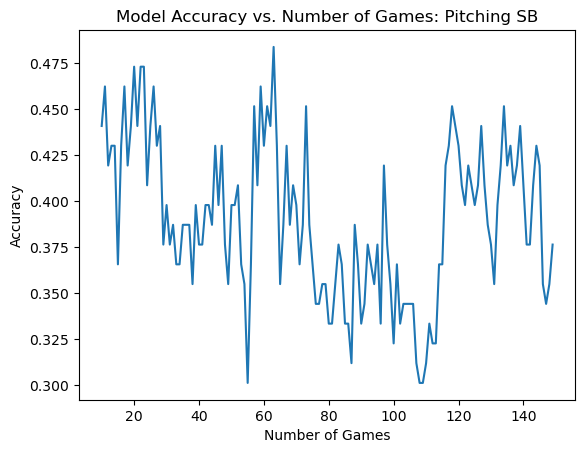

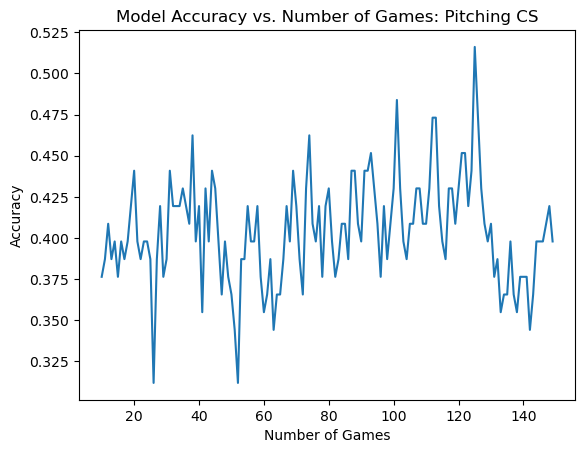

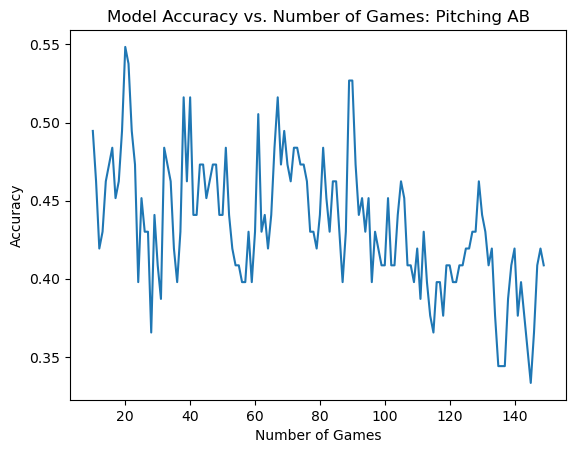

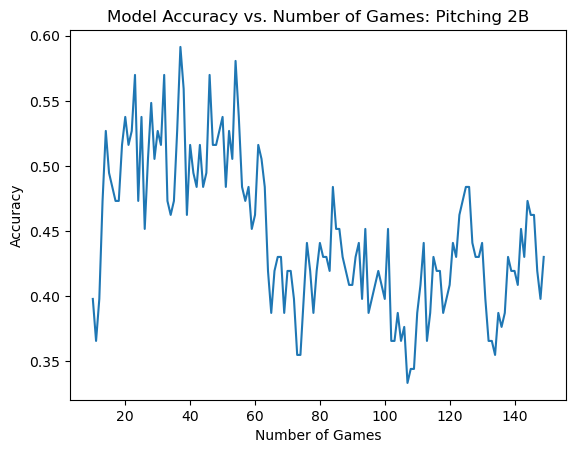

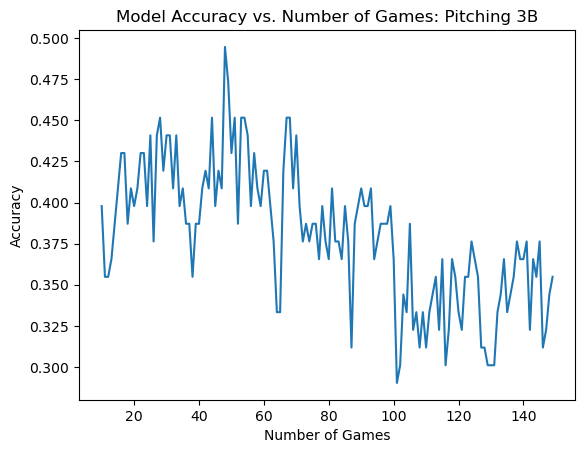

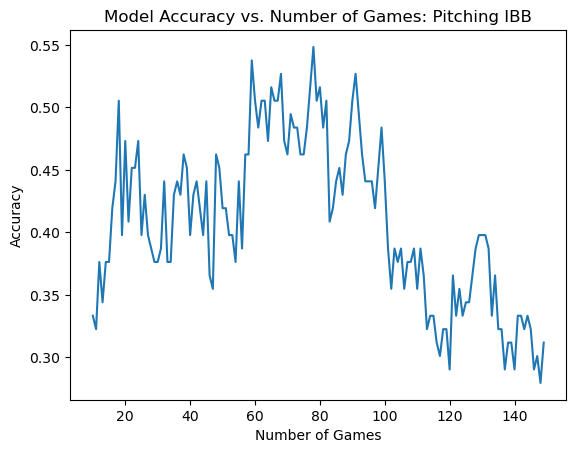

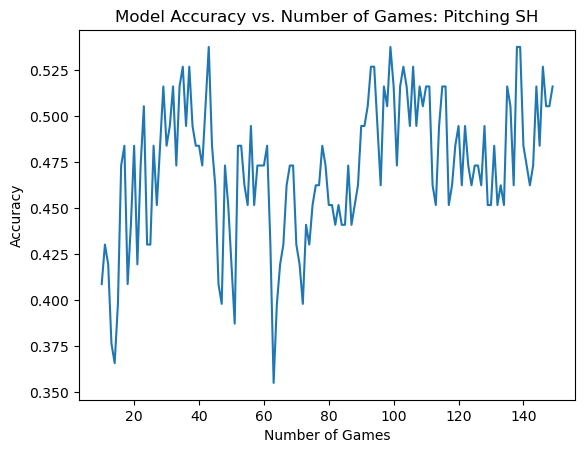

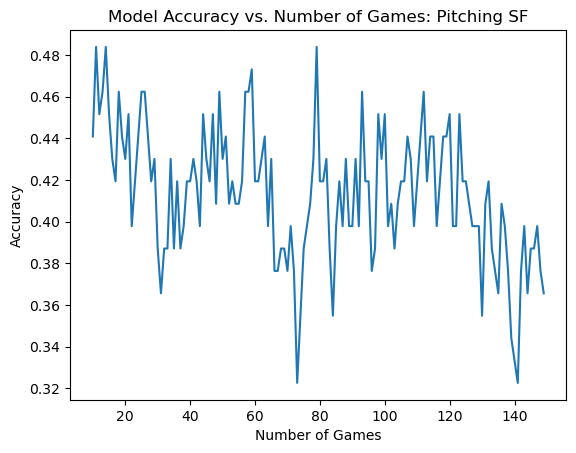

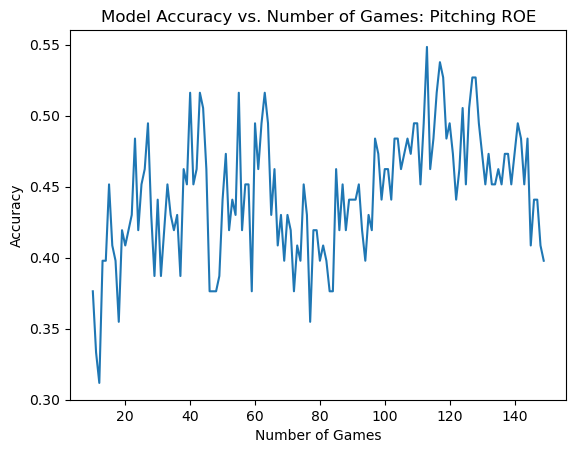

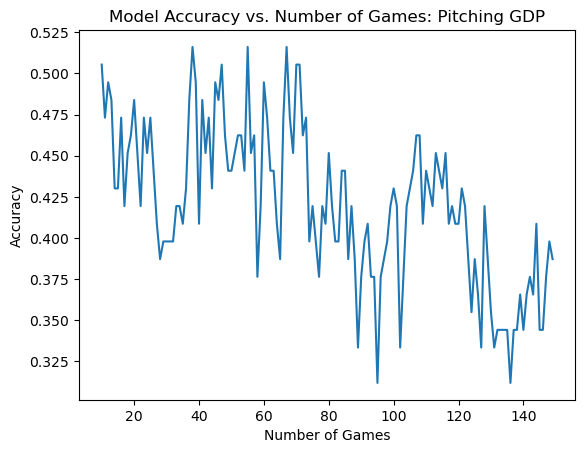

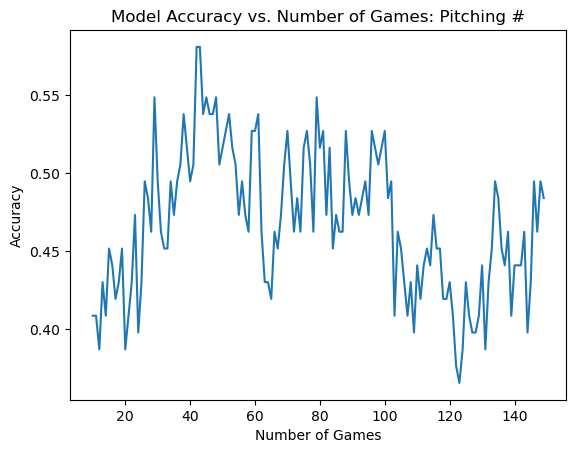

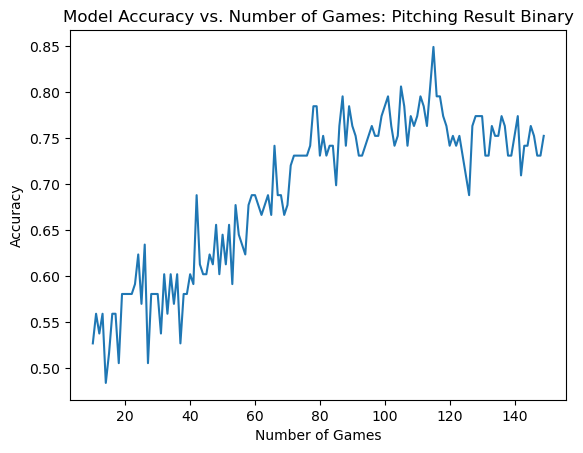

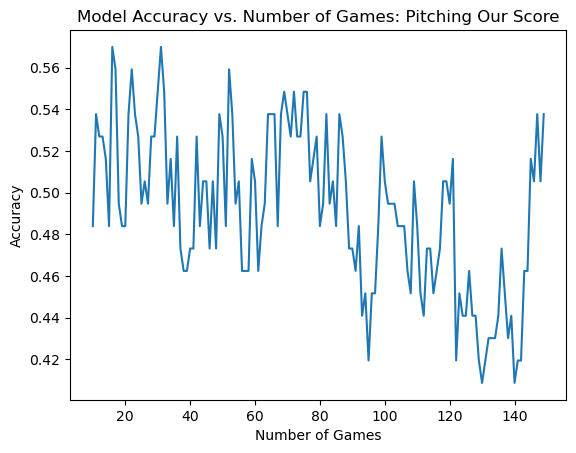

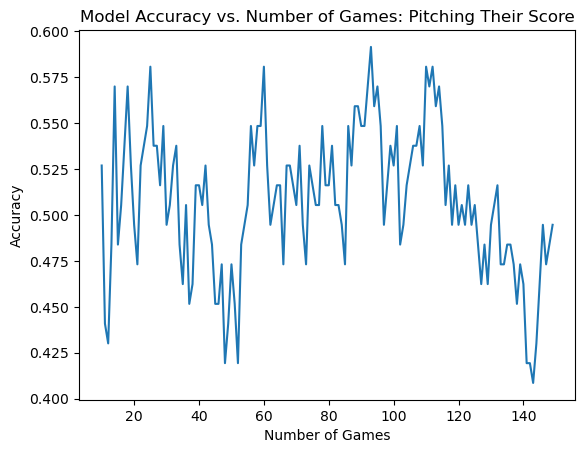

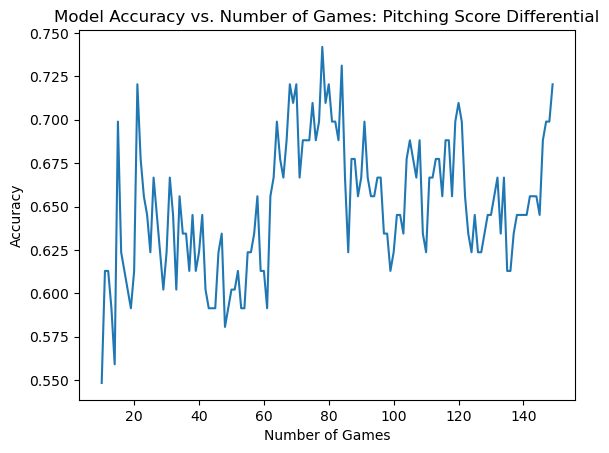

In [45]:
for i in range(len(df_list[30].columns)):
    plt.plot(num_of_games_pitching[i], pitching_prediction_accuracy[i])
    plt.title(f'Model Accuracy vs. Number of Games: Pitching {df_list[30].columns[i]}')
    plt.xlabel(f'Number of Games')
    plt.ylabel(f'Accuracy')
    plt.savefig(f'Pitching Model Accuracy__{df_list[30].columns[i]}.jpg')
    plt.show()

# for i in range(len(df_list[30].columns)):
#     plt.plot(num_of_games_pitching[i], pitching_prediction_accuracy[i])
    
# plt.title(f'Model Accuracy vs. Number of Games: Pitching')
# plt.legend([f'{df_list[30].columns[i]}' for i in range(len(df_list[30].columns))])
# plt.xlabel(f'Number of Games')
# plt.ylabel(f'Accuracy')
# plt.savefig('Pitching Accuracy.jpg')
# plt.show()

In [60]:
avg_acc_pitching_1 = np.mean(pitching_prediction_accuracy[0:13], axis= 1)
avg_acc_pitching_2 = np.mean(pitching_prediction_accuracy[15:30], axis= 1)
avg_acc_pitching = np.concatenate((avg_acc_pitching_1, avg_acc_pitching_2))

In [63]:
# don't use indices 13 and 14 from the columns
print(f'{df_list[30].columns[29]}, average accuracy: {avg_acc_pitching[27]}')
print(f'{df_list[30].columns[26]}, average accuracy: {avg_acc_pitching[24]}')
print(f'{df_list[30].columns[9]}, average accuracy: {avg_acc_pitching[9]}')
print(f'{df_list[30].columns[1]}, average accuracy: {avg_acc_pitching[1]}')
print(f'{df_list[30].columns[6]}, average accuracy: {avg_acc_pitching[6]}')
print()
print()
print()
print(f'{df_list[30].columns[19]}, average accuracy: {avg_acc_pitching[17]}')
print(f'{df_list[30].columns[15]}, average accuracy: {avg_acc_pitching[13]}')
print(f'{df_list[30].columns[8]}, average accuracy: {avg_acc_pitching[8]}')
print(f'{df_list[30].columns[16]}, average accuracy: {avg_acc_pitching[14]}')
print(f'{df_list[30].columns[20]}, average accuracy: {avg_acc_pitching[18]}')

Score Differential, average accuracy: 0.650537634408602
Result Binary, average accuracy: 0.6915514592933949
ERA, average accuracy: 0.5894777265745008
H, average accuracy: 0.5377880184331797
SO, average accuracy: 0.5559907834101383



3B, average accuracy: 0.3804915514592935
SB, average accuracy: 0.3900153609831029
HBP, average accuracy: 0.4
CS, average accuracy: 0.4039170506912443
IBB, average accuracy: 0.4085253456221199
